In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import random
from sklearn.manifold import TSNE
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE

In [2]:
df_raw = pd.read_csv("magic04.csv", header=None)
#print(df_raw)

In [3]:
y = df_raw.iloc[:,-1]
x = df_raw.iloc[:,0:-1]
x = (x - x.min()) / (x.max() - x.min()) #normalized x

#Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

y_train = pd.get_dummies(y_train)
df_train = pd.concat([x_train, y_train], axis =1)
df_train



,0,1,2,3,4,5,6,7,8,9,-1,1
7661,0.100643,0.062253,0.236399,0.379475,0.305082,0.472722,0.623240,0.497314,0.403406,0.398210,0,1
3484,0.033287,0.022660,0.085985,0.606092,0.485702,0.452645,0.595642,0.547883,0.791823,0.501027,1,0
1925,0.105460,0.052171,0.223625,0.380270,0.291154,0.469575,0.562068,0.561622,0.855080,0.252783,1,0
16486,0.075391,0.075462,0.206298,0.389590,0.287005,0.471839,0.621432,0.572738,0.257744,0.407518,0,1
951,0.100907,0.039452,0.249556,0.490056,0.333531,0.473429,0.613913,0.550684,0.751378,0.288017,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10955,0.237732,0.128854,0.524276,0.170701,0.124907,0.471815,0.689076,0.583013,0.013511,0.586423,0,1
17289,0.026428,0.041680,0.050562,0.845210,0.726033,0.430419,0.588668,0.552742,0.755011,0.405802,0,1
5192,0.164361,0.038484,0.290035,0.301852,0.206105,0.497152,0.659460,0.523370,0.114679,0.429006,1,0
12172,0.061156,0.054512,0.117150,0.544266,0.445696,0.453041,0.605560,0.567057,0.605489,0.380758,0,1


In [4]:
# 1 greater than 4369 values than -1
# generate 4369 sample for -1

df_train_1 = df_train[df_train.iloc[:,-1]==1]
df_train_n1 = df_train[df_train.iloc[:,-2]==1]
print("df_train_1:", df_train_1.shape)
print("df_train_n1:", df_train_n1.shape)
#y_train.shape




df_train_1: (9633, 12)
df_train_n1: (5264, 12)


In [5]:

x = df_train_n1.iloc[:,:-2 ]
y = df_train_n1.iloc[:,-2: ]
print(y)

y = torch.Tensor(y.values)
x = torch.Tensor(x.values)

      -1   1
3484   1   0
1925   1   0
951    1   0
1935   1   0
5393   1   0
...   ..  ..
2962   1   0
3462   1   0
144    1   0
5192   1   0
235    1   0

[5264 rows x 2 columns]


In [6]:
#Generate Data for minority class M

class VariationalAutoencoder(nn.Module):
    def __init__(self, num_features=5, num_dim=10):
        super(VariationalAutoencoder, self).__init__()
        
        self.num_features = num_features
        self.num_dim = num_dim
        
        self.encoder_layer_1 = nn.Linear(in_features=self.num_dim, out_features=5)
        self.encoder_layer_2 = nn.Linear(in_features=5, out_features=(self.num_features * 2))
        
        self.decoder_layer_1 = nn.Linear(in_features=self.num_features, out_features=5)
        self.decoder_layer_2 = nn.Linear(in_features=5, out_features=self.num_dim)
        
        self.relu = nn.ReLU() # hidden layers
        self.sigmoid = nn.Sigmoid() # output layer
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std)  # `randn_like` as we need the same size
        sample = mu + (eps * std)    # sampling as if coming from the input space
        
        return sample
    
    def encode(self, x):
        # encoding
        #x = F.relu(self.encoder_layer_1(x))
        x = self.encoder_layer_1(x)
        x = self.relu(x)
        x = self.encoder_layer_2(x).view(-1, 2, self.num_features)
        
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        
        return z, mu, log_var
    
    def decode(self, z, mu, log_var):
        # decoding
        #x = F.relu(self.decoder_layer_1(z))
        x = self.decoder_layer_1(z)
        x = self.relu(x)
        
        #reconstruction = torch.sigmoid(self.decoder_layer_2(x))
        reconstruction = self.decoder_layer_2(x)
        reconstruction = self.sigmoid(reconstruction)
        
        return reconstruction, mu, log_var
    
    # Utility function to generate new data based on:
    # mu: The average that you want to have (should be the same size as num_features)
    # log_var: The variance that you want to have (should be the same size as num_features)
    def sample(self, mu, log_var):
        z = self.reparameterize(mu, log_var)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction
        
    
    def forward(self, x):
        
        z, mu, log_var = self.encode(x)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction, mu, log_var

In [7]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class AutoencoderDataset(Dataset):
    def __init__(self, x):
        self.x = x
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.x[index]

In [8]:
# The final loss is a combination of the reconstruction loss (first argument) and the loss from an assumed distribution (i.e. Normal / Gaussian distribution)
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [9]:
num_features = 5
model = VariationalAutoencoder(num_features=num_features)

In [10]:
learning_rate = 0.00001
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 10

In [11]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        reconstruction, mu, logvar = model.forward(data)
        
        loss = loss_fn(reconstruction, targets)
        
        loss = final_loss(loss, mu, logvar)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

In [12]:
# use Dataloader for Autoencoder 
custom_dataset = AutoencoderDataset(x)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

In [13]:
epochs = 50
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
#     state = { 'state_dict': model.state_dict() }
#     torch.save(state, "magic04_model.pth")

Epoch: 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 329.08it/s, loss=1.91]


Ave Loss: 4.006276667909785
Epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 324.99it/s, loss=1.84]


Ave Loss: 3.763848451102255
Epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 281.74it/s, loss=1.78]


Ave Loss: 3.548168996932158
Epoch: 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 270.74it/s, loss=1.69]


Ave Loss: 3.3524055806690196
Epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 275.25it/s, loss=1.63]


Ave Loss: 3.1747907911351327
Epoch: 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 274.89it/s, loss=1.55]


Ave Loss: 3.0137582562680034
Epoch: 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 273.57it/s, loss=1.51]


Ave Loss: 2.8684725243407363
Epoch: 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 269.43it/s, loss=1.47]


Ave Loss: 2.7360549203811155
Epoch: 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 277.90it/s, loss=1.42]


Ave Loss: 2.6173481183441134
Epoch: 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 276.01it/s, loss=1.37]


Ave Loss: 2.511481563778032
Epoch: 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 277.10it/s, loss=1.34]


Ave Loss: 2.414835315501667
Epoch: 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 275.75it/s, loss=1.31]


Ave Loss: 2.3271827892288988
Epoch: 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 273.76it/s, loss=1.29]


Ave Loss: 2.2442710922157967
Epoch: 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 275.37it/s, loss=1.26]


Ave Loss: 2.1636347340904107
Epoch: 14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 275.84it/s, loss=1.22]


Ave Loss: 2.0855716315347284
Epoch: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 268.71it/s, loss=1.2]


Ave Loss: 2.0088306052408815
Epoch: 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 276.89it/s, loss=1.16]


Ave Loss: 1.9339335955523902
Epoch: 17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 273.78it/s, loss=1.15]


Ave Loss: 1.8607899034272108
Epoch: 18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 273.30it/s, loss=1.12]


Ave Loss: 1.7890519100529418
Epoch: 19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 282.23it/s, loss=1.08]


Ave Loss: 1.7192181219864615
Epoch: 20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 285.67it/s, loss=1.05]


Ave Loss: 1.6516361510278603
Epoch: 21


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 281.59it/s, loss=1.03]


Ave Loss: 1.5857777389674756
Epoch: 22


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 283.27it/s, loss=1.01]


Ave Loss: 1.5214265960443631
Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 283.72it/s, loss=0.977]


Ave Loss: 1.4594621771426988
Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 284.49it/s, loss=0.954]


Ave Loss: 1.3991788393858489
Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 280.32it/s, loss=0.923]


Ave Loss: 1.341491771830101
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 283.72it/s, loss=0.913]


Ave Loss: 1.2862996966834312
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 283.40it/s, loss=0.895]


Ave Loss: 1.233740757267208
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 285.70it/s, loss=0.877]


Ave Loss: 1.1833519425518826
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 285.99it/s, loss=0.855]


Ave Loss: 1.135834159842026
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 285.87it/s, loss=0.833]


Ave Loss: 1.0912127112527952
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 282.74it/s, loss=0.824]


Ave Loss: 1.0483815772936058
Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 285.55it/s, loss=0.801]


Ave Loss: 1.0090353425585115
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 282.46it/s, loss=0.784]


Ave Loss: 0.9719942662249933
Epoch: 34


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 284.10it/s, loss=0.78]


Ave Loss: 0.9378225119109398
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 286.04it/s, loss=0.775]


Ave Loss: 0.9063769652449881
Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 285.06it/s, loss=0.762]


Ave Loss: 0.877918700226344
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 281.83it/s, loss=0.742]


Ave Loss: 0.8518780937004813
Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 284.44it/s, loss=0.734]


Ave Loss: 0.8280844426019368
Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 277.11it/s, loss=0.734]


Ave Loss: 0.8066300080216134
Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:02<00:00, 257.79it/s, loss=0.714]


Ave Loss: 0.7869915772208227
Epoch: 41


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 276.41it/s, loss=0.71]


Ave Loss: 0.7686094681271113
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 283.58it/s, loss=0.705]


Ave Loss: 0.7521533696882187
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 282.07it/s, loss=0.693]


Ave Loss: 0.7364186350489477
Epoch: 44


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 266.16it/s, loss=0.68]


Ave Loss: 0.7225166010675665
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 282.59it/s, loss=0.693]


Ave Loss: 0.7095856761570447
Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 286.86it/s, loss=0.691]


Ave Loss: 0.6982753229322198
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 282.59it/s, loss=0.678]


Ave Loss: 0.6885497417350421
Epoch: 48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 277.08it/s, loss=0.68]


Ave Loss: 0.6800526508343966
Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:01<00:00, 270.65it/s, loss=0.666]

Ave Loss: 0.6731035373468779


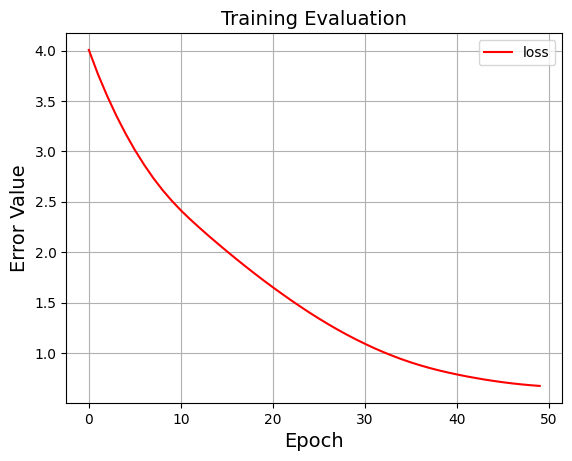

In [14]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [15]:
# Create a vector of zero tensors representing 0 average per num_feature (right in the middle of the dist)
sampled_mu = torch.Tensor([np.zeros(num_features)])

# Create a vector of zero tensors representing 0 standard deviations away from the mean to create variations
# Change this is you want to sample away from the mean to create "off-quality" data
sampled_logvar = torch.Tensor([np.zeros(num_features)])

print(sampled_logvar)

sampled_logvar.shape

tensor([[0., 0., 0., 0., 0.]])


C:\Users\wmagampoadmin\AppData\Local\Temp\ipykernel_14696\563129376.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  sampled_mu = torch.Tensor([np.zeros(num_features)])


torch.Size([1, 5])

In [16]:
# Grab a reconstructed sample from the trained model
# NOTE: reconstruction returns as an array because it's possible to have multiple predictions later on
reconstruction = model.sample(sampled_mu, sampled_logvar)

In [17]:
reconstructed_data = reconstruction[0].detach().cpu().numpy()
#reconstructed_image = reconstructed_image.reshape(img_width, img_height)
#plt.imshow(reconstructed_image)
print(reconstructed_data)
print("shape: ", reconstructed_data.shape)

[0.34197748 0.3680937  0.4646276  0.4297622  0.46999553 0.50624007
 0.49871027 0.54845977 0.53485215 0.43018427]
shape:  (10,)


In [18]:
#Generate 115 sampling
reconstructed_sample = []
added_y = []

for i in range(4369):
    reconstruction = model.sample(sampled_mu, sampled_logvar)
    reconstructed_sample.append(reconstruction[0].detach().cpu().numpy())
    added_y.append([1,0])
    #print (reconstruction[0].detach().cpu().numpy())
    
    
# print(added_y)
# print(reconstructed_sample)

In [19]:
x = df_train_n1.iloc[:,:-2 ]
y = df_train_n1.iloc[:,-2: ]


columns = [0,1,2,3,4,5,6,7,8,9]
df_reconstructed_sample = pd.DataFrame(reconstructed_sample) # Making the reconstructed output as dataframe


# synching the column names for each df
df_reconstructed_sample.columns = columns 
x.columns = columns

# ==================================
# Generate fabricated data set
# ==================================
fab_x = x.append(df_reconstructed_sample, ignore_index=True) # Append x + constructed data
print(fab_x)

# 285 columns

fab_y = pd.DataFrame(added_y, columns=[-1, 1])
fab_y = y.append(fab_y, ignore_index=True)
print(fab_y)

print(fab_x.shape)
print(fab_y.shape)


             0         1         2         3         4         5         6  \
0     0.033287  0.022660  0.085985  0.606092  0.485702  0.452645  0.595642   
1     0.105460  0.052171  0.223625  0.380270  0.291154  0.469575  0.562068   
2     0.100907  0.039452  0.249556  0.490056  0.333531  0.473429  0.613913   
3     0.450576  0.439280  0.455381  0.148540  0.086383  0.619132  0.761848   
4     0.222393  0.146048  0.306121  0.275372  0.239591  0.388452  0.528679   
...        ...       ...       ...       ...       ...       ...       ...   
9628  0.353016  0.374732  0.449453  0.416063  0.484804  0.533126  0.492632   
9629  0.364643  0.380667  0.449359  0.424264  0.487779  0.525932  0.502722   
9630  0.336956  0.347080  0.447576  0.420359  0.476384  0.488227  0.517435   
9631  0.337519  0.434994  0.417407  0.457036  0.459228  0.471427  0.578645   
9632  0.279207  0.248055  0.428088  0.442542  0.463168  0.316138  0.624166   

             7         8         9  
0     0.547883  0.791823  

C:\Users\wmagampoadmin\AppData\Local\Temp\ipykernel_14696\2102265094.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fab_x = x.append(df_reconstructed_sample, ignore_index=True) # Append x + constructed data
C:\Users\wmagampoadmin\AppData\Local\Temp\ipykernel_14696\2102265094.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fab_y = y.append(fab_y, ignore_index=True)


### Train Neural Network using fab data

In [20]:
fab_y = torch.Tensor(fab_y.values)
fab_x = torch.Tensor(fab_x.values)


class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 5) # input to first hidden layer                        
        
        self.output_layer = nn.Linear(5, self.out_dim)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.hidden_layer_1(x)
        x = self.activation(x)        
        
        y = self.output_layer(x)
        y = self.activation(y)
        
        return y

In [21]:
model = NeuralNetwork(10, 2)

# Test structure of model
predictions = model.forward(fab_x)

In [22]:
learning_rate = 0.0001

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 50

In [23]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset_2(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [24]:
def train_fn_2(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        predictions = model.forward(data)
        
        loss = loss_fn(predictions, targets)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
custom_dataset = MyCustomDataset_2(x=fab_x, y=fab_y)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 100
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn_2(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    state = { 'state_dict': model.state_dict() }

    torch.save(state, "magic04_model.pth")

Epoch: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 218.22it/s, loss=0.258]


Ave Loss: 0.26817582956867514
Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 326.92it/s, loss=0.238]


Ave Loss: 0.247932193810458
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 328.23it/s, loss=0.219]


Ave Loss: 0.22869088790268477
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 328.43it/s, loss=0.201]


Ave Loss: 0.21042106953000775
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 321.10it/s, loss=0.184]


Ave Loss: 0.19314881248177643
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 333.83it/s, loss=0.168]


Ave Loss: 0.17690044587449089
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 346.48it/s, loss=0.153]


Ave Loss: 0.16169434507893773
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 324.35it/s, loss=0.139]


Ave Loss: 0.14753747959211083
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 332.50it/s, loss=0.126]


Ave Loss: 0.13442364713379756
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 332.84it/s, loss=0.115]


Ave Loss: 0.12233307019570949
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 347.94it/s, loss=0.104]


Ave Loss: 0.11123323853615034
Epoch: 11


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 341.68it/s, loss=0.0942]


Ave Loss: 0.10108082679732476
Epoch: 12


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 339.58it/s, loss=0.0854]


Ave Loss: 0.09182410262563685
Epoch: 13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 339.22it/s, loss=0.0774]


Ave Loss: 0.0834055031828312
Epoch: 14


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 343.03it/s, loss=0.0702]


Ave Loss: 0.07576430237663842
Epoch: 15


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 342.01it/s, loss=0.0637]


Ave Loss: 0.06883872655543638
Epoch: 16


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 340.78it/s, loss=0.0578]


Ave Loss: 0.06256785693486737
Epoch: 17


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 337.43it/s, loss=0.0525]


Ave Loss: 0.0568929375028672
Epoch: 18


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 342.07it/s, loss=0.0477]


Ave Loss: 0.05175838374334914
Epoch: 19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 349.38it/s, loss=0.0434]


Ave Loss: 0.047112267425795294
Epoch: 20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 353.31it/s, loss=0.0395]


Ave Loss: 0.042906689925669386
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 352.06it/s, loss=0.036]


Ave Loss: 0.039097804344534255
Epoch: 22


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 344.33it/s, loss=0.0328]


Ave Loss: 0.035645724636131
Epoch: 23


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 357.72it/s, loss=0.0299]


Ave Loss: 0.03251438974909523
Epoch: 24


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 357.29it/s, loss=0.0273]


Ave Loss: 0.0296713056554294
Epoch: 25


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 361.77it/s, loss=0.0249]


Ave Loss: 0.02708726005696262
Epoch: 26


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 336.47it/s, loss=0.0227]


Ave Loss: 0.024736071188832812
Epoch: 27


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 342.20it/s, loss=0.0208]


Ave Loss: 0.02259425729165732
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 345.27it/s, loss=0.019]


Ave Loss: 0.0206407655918382
Epoch: 29


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 339.43it/s, loss=0.0173]


Ave Loss: 0.018856838374480683
Epoch: 30


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 340.72it/s, loss=0.0158]


Ave Loss: 0.01722569330330031
Epoch: 31


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 352.73it/s, loss=0.0145]


Ave Loss: 0.01573240635385785
Epoch: 32


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 326.35it/s, loss=0.0132]


Ave Loss: 0.014363723734654292
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 360.90it/s, loss=0.012]


Ave Loss: 0.01310792806138492
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 341.00it/s, loss=0.011]


Ave Loss: 0.011954731838729407
Epoch: 35


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 335.02it/s, loss=0.01]


Ave Loss: 0.010895140198845937
Epoch: 36


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 344.20it/s, loss=0.0091]


Ave Loss: 0.0099213238409841
Epoch: 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 360.32it/s, loss=0.00827]


Ave Loss: 0.00902647481159997
Epoch: 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 344.95it/s, loss=0.00751]


Ave Loss: 0.008204654476803202
Epoch: 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 359.48it/s, loss=0.00681]


Ave Loss: 0.007450610934877334
Epoch: 40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 340.80it/s, loss=0.00617]


Ave Loss: 0.006759618799843936
Epoch: 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 355.42it/s, loss=0.00559]


Ave Loss: 0.006127373004148815
Epoch: 42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 357.83it/s, loss=0.00506]


Ave Loss: 0.00554983479747732
Epoch: 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 338.36it/s, loss=0.00457]


Ave Loss: 0.005023183848786076
Epoch: 44


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 346.06it/s, loss=0.00413]


Ave Loss: 0.004543763570912144
Epoch: 45


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 344.70it/s, loss=0.00373]


Ave Loss: 0.004108066453448849
Epoch: 46


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 356.30it/s, loss=0.00336]


Ave Loss: 0.003712720121860195
Epoch: 47


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 348.24it/s, loss=0.00303]


Ave Loss: 0.0033544994133085475
Epoch: 48


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 352.32it/s, loss=0.00274]


Ave Loss: 0.0030303339997470534
Epoch: 49


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 347.41it/s, loss=0.00247]


Ave Loss: 0.0027373109936926496
Epoch: 50


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 347.16it/s, loss=0.00223]


Ave Loss: 0.002472690877219942
Epoch: 51


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 343.01it/s, loss=0.00201]


Ave Loss: 0.002233912349181549
Epoch: 52


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 343.31it/s, loss=0.00181]


Ave Loss: 0.002018589601813396
Epoch: 53


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 354.48it/s, loss=0.00163]


Ave Loss: 0.0018245122248277917
Epoch: 54


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 335.73it/s, loss=0.00147]


Ave Loss: 0.0016496393122647556
Epoch: 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 332.30it/s, loss=0.00133]


Ave Loss: 0.0014921060595613146
Epoch: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 350.03it/s, loss=0.0012]


Ave Loss: 0.0013502045538170272
Epoch: 57


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 358.89it/s, loss=0.00109]


Ave Loss: 0.0012223726576387187
Epoch: 58


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 353.58it/s, loss=0.000984]


Ave Loss: 0.0011071974479163866
Epoch: 59


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 356.62it/s, loss=0.000891]


Ave Loss: 0.0010034010858381158
Epoch: 60


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 362.53it/s, loss=0.000807]


Ave Loss: 0.0009098276308945192
Epoch: 61


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 353.26it/s, loss=0.000731]


Ave Loss: 0.0008254342931419263
Epoch: 62


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 354.01it/s, loss=0.000663]


Ave Loss: 0.0007492838978738442
Epoch: 63


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 353.41it/s, loss=0.000601]


Ave Loss: 0.0006805350542565509
Epoch: 64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 356.33it/s, loss=0.000546]


Ave Loss: 0.0006184337915215699
Epoch: 65


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 357.56it/s, loss=0.000496]


Ave Loss: 0.0005623050129953096
Epoch: 66


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 355.43it/s, loss=0.000451]


Ave Loss: 0.0005115415699480806
Epoch: 67


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 357.89it/s, loss=0.00041]


Ave Loss: 0.00046560100618740205
Epoch: 68


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 351.72it/s, loss=0.000373]


Ave Loss: 0.00042399885392279746
Epoch: 69


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 342.64it/s, loss=0.00034]


Ave Loss: 0.0003863005302339754
Epoch: 70


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 344.85it/s, loss=0.000309]


Ave Loss: 0.00035211918383976684
Epoch: 71


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 351.86it/s, loss=0.000282]


Ave Loss: 0.0003211067636905074
Epoch: 72


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 355.17it/s, loss=0.000257]


Ave Loss: 0.00029295142556038815
Epoch: 73


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 355.84it/s, loss=0.000234]


Ave Loss: 0.0002673748385105668
Epoch: 74


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 352.45it/s, loss=0.000214]


Ave Loss: 0.00024412697922423908
Epoch: 75


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 345.44it/s, loss=0.000195]


Ave Loss: 0.00022298360992599413
Epoch: 76


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 349.47it/s, loss=0.000178]


Ave Loss: 0.0002037436147781398
Epoch: 77


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 347.96it/s, loss=0.000163]


Ave Loss: 0.00018622690289693888
Epoch: 78


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 348.26it/s, loss=0.000149]


Ave Loss: 0.00017027057592100778
Epoch: 79


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 347.43it/s, loss=0.000136]


Ave Loss: 0.00015572852847453477
Epoch: 80


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 352.57it/s, loss=0.000125]


Ave Loss: 0.00014246923009348658
Epoch: 81


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 353.62it/s, loss=0.000114]


Ave Loss: 0.00013037393228639487
Epoch: 82


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 358.40it/s, loss=0.000104]


Ave Loss: 0.00011933634349131726
Epoch: 83


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 352.39it/s, loss=9.55e-5]


Ave Loss: 0.00010925945615512922
Epoch: 84


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 354.87it/s, loss=8.75e-5]


Ave Loss: 0.00010005598668391464
Epoch: 85


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 347.00it/s, loss=8.01e-5]


Ave Loss: 9.164721208143198e-05
Epoch: 86


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 356.15it/s, loss=7.34e-5]


Ave Loss: 8.396223500199674e-05
Epoch: 87


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 355.52it/s, loss=6.73e-5]


Ave Loss: 7.693642699714615e-05
Epoch: 88


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 350.04it/s, loss=6.16e-5]


Ave Loss: 7.051110351029928e-05
Epoch: 89


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 359.93it/s, loss=5.65e-5]


Ave Loss: 6.463325894519161e-05
Epoch: 90


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 359.82it/s, loss=5.18e-5]


Ave Loss: 5.9254809023801557e-05
Epoch: 91


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 352.20it/s, loss=4.75e-5]


Ave Loss: 5.433202763477104e-05
Epoch: 92


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 349.24it/s, loss=4.36e-5]


Ave Loss: 4.9825251893227236e-05
Epoch: 93


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 353.20it/s, loss=4e-5]


Ave Loss: 4.569826932042509e-05
Epoch: 94


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 352.61it/s, loss=3.67e-5]


Ave Loss: 4.191822114513965e-05
Epoch: 95


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 356.07it/s, loss=3.37e-5]


Ave Loss: 3.845523565949105e-05
Epoch: 96


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 357.40it/s, loss=3.09e-5]


Ave Loss: 3.5282181778867185e-05
Epoch: 97


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 357.52it/s, loss=2.83e-5]


Ave Loss: 3.237431911737152e-05
Epoch: 98


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 349.84it/s, loss=2.6e-5]


Ave Loss: 2.9709009710989452e-05
Epoch: 99


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 357.00it/s, loss=2.39e-5]

Ave Loss: 2.726565946120928e-05


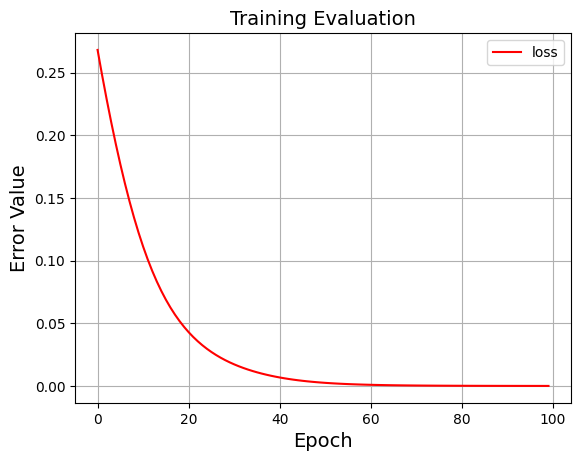

In [25]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [26]:
y_test = pd.get_dummies(y_test)
# y_test = torch.Tensor(y_test.values)
x_test = torch.Tensor(x_test.values)

model = NeuralNetwork(10, 2)

predictions = model.forward(x_test)
preds = predictions.detach().cpu().numpy()

ohe = []
for i in preds:
       if i[0] > i[1]:
         ohe.append([1,0])
       else:
        ohe.append([0,1])
#preds
ohe

acc = accuracy_score(ohe, y_test)
cl_report = classification_report(ohe, y_test)
print("acc: ", acc)
print("cl report: ", cl_report)

acc:  0.6332885906040269
cl report:                precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.63      0.78      3725

   micro avg       0.63      0.63      0.63      3725
   macro avg       0.50      0.32      0.39      3725
weighted avg       1.00      0.63      0.78      3725
 samples avg       0.63      0.63      0.63      3725



D:\Data Engineering Class\NeuralNetwork_contest\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
